In [2]:
import os
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    LeakyReLU,
    Input,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
)
from sklearn.metrics import classification_report
import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [3]:
dirname = os.path.join(os.getcwd(), "data", "images")
filenames = os.listdir(dirname)
print(filenames)

images = []
directories = []
dircount = []
prevRoot = ""
cant = 0

print("leyendo imagenes de ", dirname)

for root, dirnames, filenames in os.walk(dirname):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant = cant + 1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            if prevRoot != root:
                prevRoot = root
                directories.append(root)
                dircount.append(cant)
                cant = 0
dircount.append(cant)

dircount = dircount[1:]
dircount[0] = dircount[0] + 1
print("Directorios leidos:", len(directories))
print("Imagenes en cada directorio", dircount)
print("suma Total de imagenes en subdirs:", sum(dircount))

<>:15: SyntaxWarning: invalid escape sequence '\.'
<>:15: SyntaxWarning: invalid escape sequence '\.'
C:\Users\David\AppData\Local\Temp\ipykernel_21020\73360885.py:15: SyntaxWarning: invalid escape sequence '\.'
  if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):


['hummer', 'mazda3', 'mini', 'tsuru', 'vocho']
leyendo imagenes de  c:\Users\David\ia\cnn\data\images
Directorios leidos: 5
Imagenes en cada directorio [4142, 3569, 5085, 1804, 4105]
suma Total de imagenes en subdirs: 18705


In [4]:
labels = []
indice = 0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice = indice + 1
print("Cantidad etiquetas creadas: ", len(labels))

Cantidad etiquetas creadas:  18705


In [5]:
sriesgos = []
indice = 0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice, name[len(name) - 1])
    sriesgos.append(name[len(name) - 1])
    indice = indice + 1

0 hummer
1 mazda3
2 mini
3 tsuru
4 vocho


In [6]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8)  # convierto de lista a numpy

classes = np.unique(y)
nClasses = len(classes)
print("Total number of outputs : ", nClasses)
print("Output classes : ", classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2)
print("Training data shape : ", train_X.shape, train_Y.shape)
print("Testing data shape : ", test_X.shape, test_Y.shape)

Training data shape :  (14964, 80, 80) (14964,)
Testing data shape :  (3741, 80, 80) (3741,)


Text(0.5, 1.0, 'Ground Truth : 0')

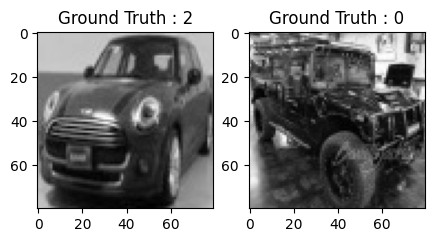

In [8]:
plt.figure(figsize=[5, 5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0, :, :], cmap="gray")
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0, :, :], cmap="gray")
plt.title("Ground Truth : {}".format(test_Y[0]))

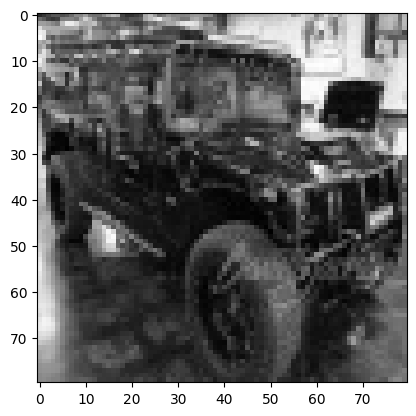

In [9]:
train_X = train_X.astype("float32")
test_X = test_X.astype("float32")
train_X = train_X / 255.0
test_X = test_X / 255.0
plt.imshow(test_X[0, :, :], cmap="gray")

In [10]:
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)
print("Original label:", train_Y[0])
print("After conversion to one-hot:", train_Y_one_hot[0])

Original label: 2
After conversion to one-hot: [0. 0. 1. 0. 0.]


In [11]:
print(f"train_X shape: {train_X.shape}")
print(f"train_Y_one_hot shape: {train_Y_one_hot.shape}")
# Mezclar todo y crear los grupos de entrenamiento y testing
train_X, valid_X, train_label, valid_label = train_test_split(
    train_X, train_Y_one_hot, test_size=0.2, random_state=13
)
print(train_X.shape, valid_X.shape, train_label.shape, valid_label.shape)

train_X shape: (14964, 80, 80)
train_Y_one_hot shape: (14964, 5)
(11971, 80, 80) (2993, 80, 80) (11971, 5) (2993, 5)


In [12]:
# declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3  # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = (
    11  # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
)
batch_size = 64  # cantidad de imágenes que se toman a la vez en memoria

In [13]:
car_model = Sequential(
    [
        Conv2D(
            32,
            (3, 3),
            activation="relu",
            input_shape=(80, 80, 1),
        ),
        MaxPooling2D((2, 2)),
        Conv2D(
            64,
            (3, 3),
            activation="relu",
        ),
        MaxPooling2D((2, 2)),
        Conv2D(
            128,
            (3, 3),
            activation="relu",
        ),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(250, activation="relu"),
        Dense(nClasses, activation="softmax"),
    ]
)

car_model.summary()

c:\Users\David\ia\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 78, 78, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 250)            │     2,048,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,142,177 (8.17 MB)

 Trainable params: 2,142,177 (8.17 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
car_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

In [15]:
car_train = car_model.fit(
    train_X,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label),
)

Epoch 1/11
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.4821 - loss: 1.2483 - val_accuracy: 0.8279 - val_loss: 0.5164
Epoch 2/11
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.8288 - loss: 0.4916 - val_accuracy: 0.9492 - val_loss: 0.1898
Epoch 3/11
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.9259 - loss: 0.2213 - val_accuracy: 0.9856 - val_loss: 0.0738
Epoch 4/11
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.9677 - loss: 0.0983 - val_accuracy: 0.9896 - val_loss: 0.0459
Epoch 5/11
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9810 - loss: 0.0616 - val_accuracy: 0.9903 - val_loss: 0.0417
Epoch 6/11
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9849 - loss: 0.0496 - val_accuracy: 0.9923 - val_loss: 0.0358
Epoch 7/11
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.9871 - loss: 0.0436 - val_accuracy: 0.9890 - val_loss: 0.0585
Epoch 8/11
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.9322 - loss: 0.2142

In [16]:
car_model.save(os.path.join(os.getcwd(), "model.h5"))

In [17]:
test_eval = car_model.evaluate(test_X, test_Y_one_hot, verbose=1)

117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9967 - loss: 0.0215


In [18]:
predicted_classes2 = car_model.predict(test_X)

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [19]:
predicted_classes=[]
for predicted_car in predicted_classes2:
    predicted_classes.append(predicted_car.tolist().index(max(predicted_car)))
predicted_classes=np.array(predicted_classes)

In [20]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       842
     Class 1       0.99      1.00      1.00       750
     Class 2       1.00      1.00      1.00       996
     Class 3       0.99      1.00      1.00       351
     Class 4       1.00      0.99      0.99       802

    accuracy                           1.00      3741
   macro avg       1.00      1.00      1.00      3741
weighted avg       1.00      1.00      1.00      3741

